<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/Autoencoder-demo/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder - 01418496 (หมู่เรียน 200)

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import shutil
import os
tf.__version__

'2.17.1'

In [2]:
import numpy as np
from PIL import Image

### Setting to execute on Processor (GPU or CPU)

In [3]:
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Execute on GPU")
else:
    print("Execute on CPU")

Execute on GPU


### Download Dataset

In [4]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("tongpython/cat-and-dog/version/1")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


## Prepossessing


In [5]:
dataset_path = "./dataset"
for dirpath, dirnames, filenames in os.walk(dataset_path):
    print(f"Path: {dirpath}, Subdirectories: {dirnames}, Files: {len(filenames)}")

Path: ./dataset, Subdirectories: ['training_set', 'test_set'], Files: 0
Path: ./dataset/training_set, Subdirectories: ['training_set'], Files: 0
Path: ./dataset/training_set/training_set, Subdirectories: ['dogs', 'cats'], Files: 0
Path: ./dataset/training_set/training_set/dogs, Subdirectories: [], Files: 4006
Path: ./dataset/training_set/training_set/cats, Subdirectories: [], Files: 4001
Path: ./dataset/test_set, Subdirectories: ['test_set'], Files: 0
Path: ./dataset/test_set/test_set, Subdirectories: ['dogs', 'cats'], Files: 0
Path: ./dataset/test_set/test_set/dogs, Subdirectories: [], Files: 1013
Path: ./dataset/test_set/test_set/cats, Subdirectories: [], Files: 1012


In [6]:
def preprocess(imgs):
    imgs = imgs.astype("float32") / 255.0  # Normalize pixel values to [0, 1]
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2), (0, 0)), constant_values=0.0)
    return imgs

def to_image(img):
    img = np.squeeze(img)
    return Image.fromarray(np.uint8(img * 255))

In [7]:
import cv2
def dataset_to_numpy_and_preprocess(dataset):
    images, labels = [], []
    for img_batch, label_batch in dataset:
        images.append(img_batch.numpy())
        labels.append(label_batch.numpy())
    imgs = np.concatenate(images)
    lbls = np.concatenate(labels)
    return preprocess(imgs), lbls

def change_gray_images(images):
    gray_images = []
    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.merge([image, image, image])
        gray_images.append(image)

    gray_images = np.array(gray_images)
    # gray_images = np.repeat(gray_images[:, :, :, np.newaxis], 3, axis=3)  # Repeat across the 3rd axis
    return gray_images

In [8]:
train_dir = "./dataset/training_set/training_set"
test_dir = "./dataset/test_set/test_set"

In [9]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(50, 50),  # Resize images
    batch_size=32,
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(50, 50),
    batch_size=32,
)

X_train, y_train = dataset_to_numpy_and_preprocess(train_dataset)
X_test, y_test = dataset_to_numpy_and_preprocess(test_dataset)
X_train_gray = change_gray_images(X_train)
X_test_gray = change_gray_images(X_test)
del train_dataset
del test_dataset

Found 8005 files belonging to 2 classes.
Found 2023 files belonging to 2 classes.


In [10]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
SHAPE = X_train.shape[1:]
print(f"Shape: {SHAPE}")

X_train shape: (8005, 54, 54, 3)
y_train shape: (8005,)
X_test shape: (2023, 54, 54, 3)
y_test shape: (2023,)
Shape: (54, 54, 3)


In [11]:
print(f"X_train_gray: {X_train_gray.shape}")
print(f"X_test_gray: {X_test_gray.shape}")
NEW_SHAPE = X_train_gray.shape[1:]
print(f"New Shape: {NEW_SHAPE}")

X_train_gray: (8005, 54, 54, 3)
X_test_gray: (2023, 54, 54, 3)
New Shape: (54, 54, 3)


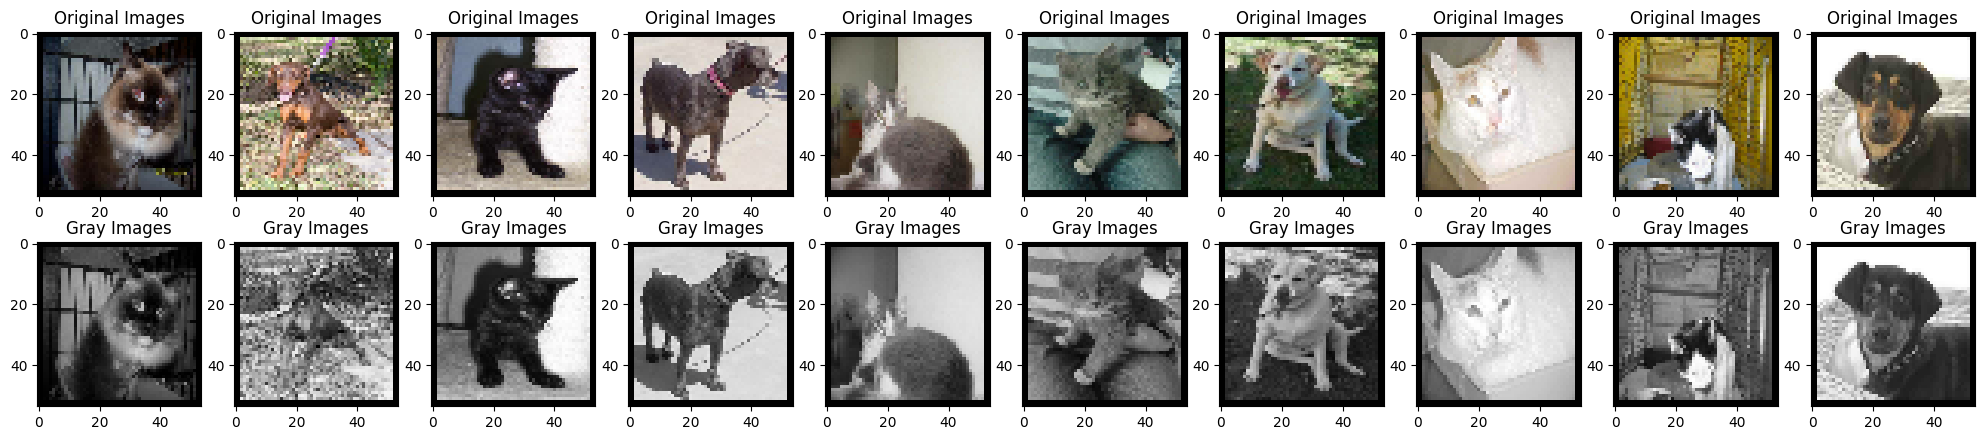

In [12]:
num_images = 10
fig = plt.figure(figsize=(25, 5))
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(X_train[i])
    plt.title("Original Images")

    plt.subplot(2, 10, i+1+num_images)
    plt.imshow(X_train_gray[i], cmap='gray')
    plt.title("Gray Images")

### Create Model by using OOP

In [13]:
from tensorflow.keras import models, layers, losses, activations, optimizers
import tensorflow.keras.backend as K

LATENT_DIM = 2

# Encoder Model
encoder_input = layers.Input(shape=SHAPE, name="Encoder_Input")

x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu, strides=2)(encoder_input)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)

shape_before_flatten = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(LATENT_DIM, activation=activations.relu, name="Encoder_Output")(x)

encoder = models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)           │ (None, 54, 54, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 27, 27, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_Output (Dense)               │ (None, 2)                   │         186,626 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 485,506 (1.85 MB)

 Trainable params: 485,506 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Decoder Model
decoder_input = layers.Input(shape=(LATENT_DIM,), name="Decoder_Input")
x = layers.Dense(tf.math.reduce_prod(shape_before_flatten).numpy(), activation=activations.relu)(decoder_input)
x = layers.Reshape(shape_before_flatten)(x)

x = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu)(x)
x = layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding='same', activation=activations.leaky_relu, strides=2)(x)

decoder_output = layers.Conv2D(filters=SHAPE[-1], kernel_size=(2, 2), padding='same', activation=activations.sigmoid, name="Decoder_Output")(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Decoder_Input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 93312)               │         279,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 27, 27, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 27, 27, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 27, 27, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 27, 27, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 54, 54, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Decoder_Output (Conv2D)              │ (None, 54, 54, 3)           │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 724,355 (2.76 MB)

 Trainable params: 724,355 (2.76 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
autoencoder = models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Encoder_Input (InputLayer)           │ (None, 54, 54, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 27, 27, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 27, 27, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 27, 27, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 27, 27, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Encoder_Output (Dense)               │ (None, 2)                   │         186,626 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_1 (Functional)            │ (None, 54, 54, 3)           │         724,355 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,861 (4.62 MB)

 Trainable params: 1,209,861 (4.62 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
EPOCH = 10
BATCH_SIZE = 100

autoencoder.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss=losses.MeanAbsoluteError)
autoencoder.fit(X_train_gray, X_train, epochs=EPOCH, validation_data=(X_test_gray, X_test), batch_size=BATCH_SIZE)

Epoch 1/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 26s 180ms/step - loss: 0.2301 - val_loss: 0.2060
Epoch 2/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 27s 113ms/step - loss: 0.1613 - val_loss: 0.1495
Epoch 3/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.1493 - val_loss: 0.1494
Epoch 4/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 0.1498 - val_loss: 0.1487
Epoch 5/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.1489 - val_loss: 0.1514
Epoch 6/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.1497 - val_loss: 0.1506
Epoch 7/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 116ms/step - loss: 0.1489 - val_loss: 0.1487
Epoch 8/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - loss: 0.1485 - val_loss: 0.1484
Epoch 9/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.1485 - val_loss: 0.1479
Epoch 10/10
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - loss: 0.1481 - val_loss: 0.1487


In [17]:
prediction = autoencoder.predict(X_test_gray)

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step


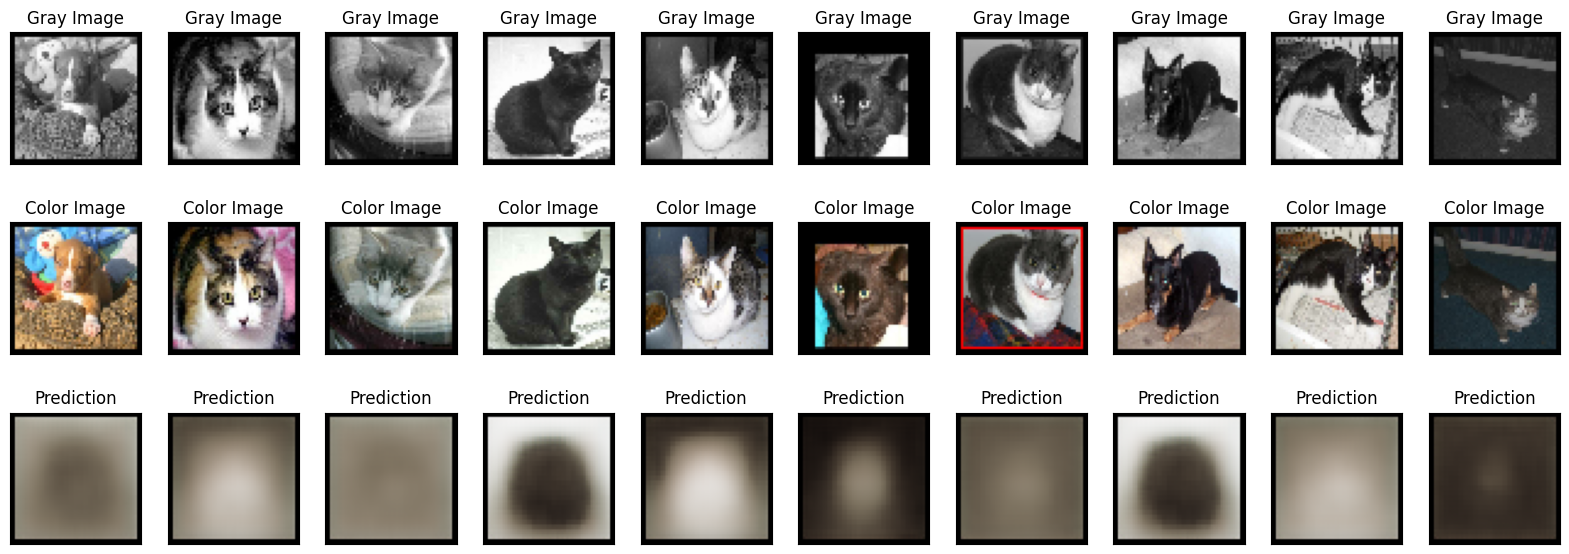

In [18]:
n = 10
plt.figure(figsize=(20, 7))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_gray[i])
    plt.title("Gray Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(X_test[i])
    plt.title("Color Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(prediction[i])
    plt.title("Prediction")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [19]:
encoder_imgs = encoder.predict(X_test_gray)

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


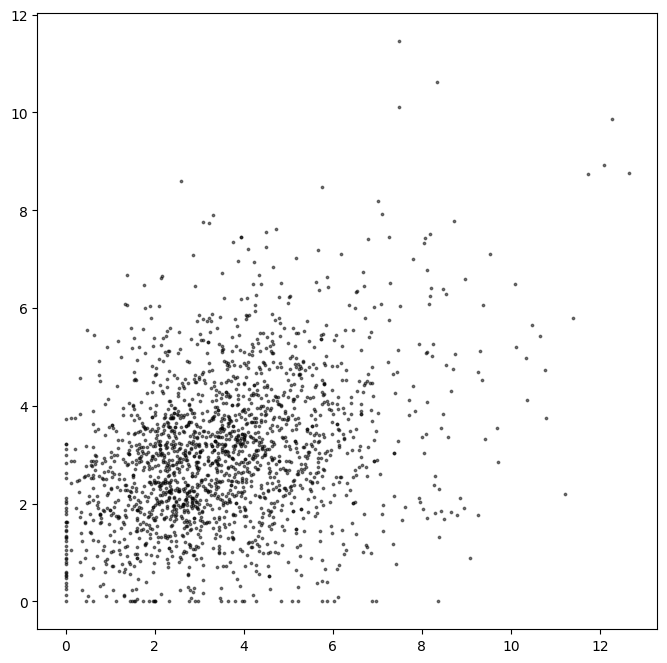

In [20]:
plt.figure(figsize=(8, 8))
plt.scatter(encoder_imgs[:, 0], encoder_imgs[:, 1], c='black', alpha=0.5, s=3)
plt.show()

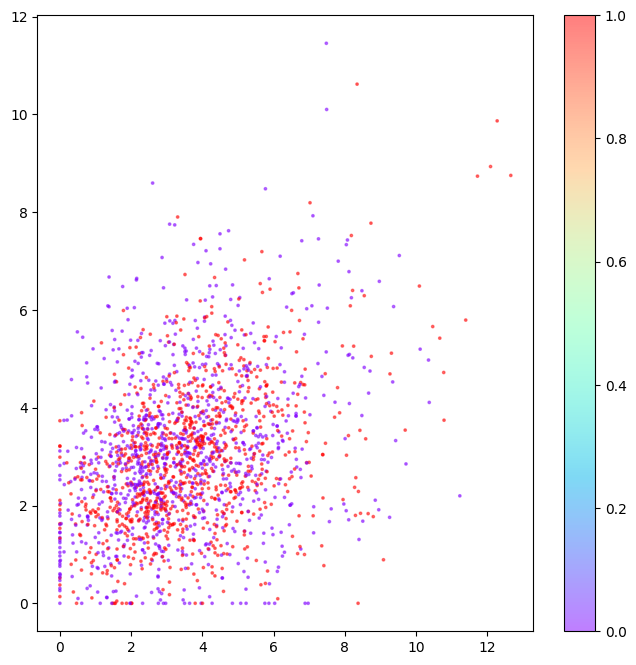

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(encoder_imgs[:, 0], encoder_imgs[:, 1], cmap='rainbow', c=y_test, alpha=0.5, s=3)
plt.colorbar()
plt.show()